<div class="span5 alert alert-info">
<h1>Data Science Salaries (ML Code)</h1>
</div>

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.utils.multiclass import unique_labels

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""For Aesthetics"""

font = {'family' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

mpl.rcParams['figure.figsize'] = (15.0, 5.0)

<div class="span5 alert alert-info">
<h2>Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: </h2>

<h3> (1) live in the USA, </h3>
    
<h3> (2) share their salary details, and </h3>

<h3> (3) are employed as Data Scientists </h3>

</div>

In [3]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

In [4]:
# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]

In [5]:
df = df[(df.Occupation=="Data Scientist")]

In [6]:
df = df.fillna("Unknown")

<div class="span5 alert alert-info">
<h2> Feature engineering </h2>
</div>

In [7]:
# Salary
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Sal_Mid'] = df.Salary.apply(lambda x: dictionary[x])    
                    
# Age
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

# Experience
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Exp_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

# 1,0 target column
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span5 alert alert-info">
    <h2> Reordering the columns and removing/merging small subgroups </h2>
    </div>

In [8]:
df = df[["Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Exp_Mid","Sal_Mid"]]

In [9]:
df = df[(df.Gender=="Male") | 
         (df.Gender=="Female")
        ]

# the apostrophes used below are not the standard ones used on a keyboard
# I copy and pasted the bachelors and masters text below from a value_counts print
df = df[(df.Education=="Bachelor’s degree") | 
          (df.Education=="Master’s degree") |
          (df.Education=="Doctoral degree")
         ]

In [10]:
dictionary = {'Master’s degree'    : "Master's", 
              'Bachelor’s degree'  : "Bachelor's",
              'Doctoral degree'    : "Doctoral"
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Other',
              'Information technology, networking, or system administration'  : 'Other',
              'Environmental science or geology'                              : 'Other', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Other',
              'I never declared a major'                                      : 'Other',
              'Unknown'                                                       : 'Other'
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Other",
              'Academics/Education'                    : "Other", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Other",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Other", 
              'Energy/Mining'                          : "Other", 
              'Retail/Sales'                           : "Other" ,
              'Military/Security/Defense'              : "Other",
              'Online Business/Internet-based Sales'   : "Other",
              'Manufacturing/Fabrication'              : "Other", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Other"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])  
                    
#Age
dictionary = {'18-21' : "Other",
              '22-24' : '22-24',
              '25-29' : '25-29',
              '30-34' : '30-34',
              '35-39' : '35-39',
              '40-44' : '40-44',
              '45-49' : '45-49',
              '50-54' : "Other",
              '55-59' : "Other",
              '60-69' : "Other",
              '70-79' : "Other",
              '80+'   : "Other"
             }
df['Age'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : '0-1',
              '1-2'    : '1-2',
              '2-3'    : '2-3',
              '3-4'    : '3-4',
              '4-5'    : '4-5',
              '5-10'   : '5-10',
              '10-15'  : '>10',
              '15-20'  : '>10',
              '20-25'  : '>10',
              '25-30'  : '>10',
              '30 +'   : '>10'
            }
df['Experience'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Binary'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span alert alert-warning">
    <h1> User-Defined Functions </h1>
    </div>

In [11]:
"""For Picking a Model Choice"""

def pick_model(model_name, x, y, scoring, train_size=0.7, standardize=False, detail=False, all_metrics=False):
    # ex) pick_model("log_reg", x, y, "accuracy")
    ## about scoring: https://scikit-learn.org/stable/modules/model_evaluation.html
    model, grid = model_grid(model_name)
    x_train, x_test, y_train, y_test = train_test_split(
                                            x, y, train_size=train_size, random_state=0)
    subdf = x_train
    subdf2 = x_test
    if standardize:
        names_train = x_train.columns
        names_test = x_test.columns
        
        scaler = preprocessing.StandardScaler()
        scaled_train = scaler.fit_transform(x_train)
        scaled_test = scaler.transform(x_test)
        
        scaled_train = pd.DataFrame(scaled_train, columns=names_train)
        scaled_test = pd.DataFrame(scaled_test, columns=names_test)
    else:
        scaled_train = subdf
        scaled_test = subdf2
    x_train = scaled_train
    x_test = scaled_test
    
    model = best_grid(model, grid, x_train, y_train, scoring)
    model = model.fit(x_train, y_train)
    report_score(model, x_train, y_train, x_test, y_test, x, scoring, detail, all_metrics)

def model_grid(model_name):
    if model_name == "log_reg":
        model = LogisticRegression()
        grid = {'C' : [0.001, 0.1, 1, 10, 100]}
        return model, grid
    
    elif model_name == "ran_for":
        model = RandomForestClassifier(random_state=0)
        grid = {'n_estimators' : [1, 30], 
                'max_features' : ['auto', 'log2'],  
                'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                'criterion' : ['gini', 'entropy']}
        return model, grid

    elif model_name == "knn":
        model = KNeighborsClassifier()
        grid = {"n_neighbors" : [3,6,9,12]}
        return model, grid

    elif model_name == "xgb":
        model = XGBClassifier()
        grid = { 
                  "max_depth"         : [2, 4, 8, 16],
                  "alpha"             : [10, 20, 30],
                  "lambda"            : [10, 20, 30],
#                  "min_child_weight" : [  1,  5],
#                  "colsample_bytree" : [ .3, .7],
#                  "learning_rate"    : [.10, .30],
#                  "gamma"            : [  0, .5, 5],
#                  "eta"              : [0.05, 0.20]
        }  
        return model, grid
        
    elif model_name == "gnb":
        model = GaussianNB()
        grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
        return model, grid

def best_grid(model, grid, x_train, y_train, scoring, n_folds=5):
    gs = GridSearchCV(model, param_grid=grid, cv=n_folds, scoring=scoring)
    # scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    
    gs.fit(x_train, y_train)
    print("BEST PARAMS               ", gs.best_params_)
    best = gs.best_estimator_
    return best

def report_score(model, x_train, y_train, x_test, y_test, x, scoring, detail, all_metrics): 
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_prob_train = model.predict_proba(x_train)[:,1]
    y_prob_test = model.predict_proba(x_test)[:,1]
    
    """ F1 (f-one) Score """
    ## F1 Score = 2*((precision*recall)/(precision+recall))
    if scoring == "f1" or all_metrics:
        f1_test = metrics.f1_score(y_test, y_pred_test)
        f1_train = metrics.f1_score(y_train, y_pred_train)
        print("F1 on test data:           {:0.3f}".format(f1_test))
        print("F1 on training data:         {:0.3f}".format(f1_train))
    
    """ Accuracy """
    ## number of correct predictions made / total number of predictions made
    ### accuracy is not always the best metric: https://en.wikipedia.org/wiki/Accuracy_paradox
    if scoring == "accuracy" or all_metrics:
        accuracy_training = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)
        print("Accuracy on test data:     {:0.2f}".format(accuracy_test))
        print("Accuracy on training data:   {:0.2f}".format(accuracy_training))
    
        
    """ ROC AUC """
    ## How well model distinguishs between classes
    ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
    #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
    if scoring == "roc_auc" or all_metrics:
        roc_auc_score_training = roc_auc_score(y_train, y_prob_train)
        roc_auc_score_test = roc_auc_score(y_test, y_prob_test)
        print("AUC on test data:          {:0.2f}".format(roc_auc_score_test))
        print("AUC on training data:        {:0.2f}\n".format(roc_auc_score_training))
        
    if detail:
        """ Confusion matrix """
        """     P   N     <- actual
            P  TP  FP 
            N  FN  TN   """
        c_matrix = confusion_matrix(y_test, y_pred_test)
        print("Confusion Matrix on test data:\n", c_matrix)

        """ Classification Report """
        ## Precision = TP / TP + FP
        ### Also known as Positive Predictive Value
        ## Recall = TP/ TP + FN
        class_repo = classification_report(y_test,y_pred_test)
        print("Classification Report on test data:\n", class_repo)

        #Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        print("")

        # Coefficients
        coefs = pd.Series(model.coef_[0], index=x.columns)
        coefs = coefs.sort_values()
        coefs.plot(kind="bar",title="Coefficients")
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=20)
        plt.show()
        #print(coefs.sort_values(ascending = False))

        # Threshold Plot
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
        f1 = []
        
        def adjust_pred_prob(y_prob_test, new_threshold):
            return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

        for t in thresholds:
            adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
            add_f1 = metrics.f1_score(y_test, adjusted_y_pred)
            f1.append(add_f1)

        ## Retrieve probability of being 1(in second column of probs_y)
        pr_auc = metrics.auc(recall, precision)

        plt.title("Precision-Recall-F1 vs Threshold Chart")
        plt.plot(thresholds, precision[: -1], "b-", label="Precision")
        plt.plot(thresholds, recall[: -1], "r-", label="Recall")
        plt.plot(thresholds, f1, "g-", label="F1_Score")
        #plt.axvline(.425, color='k', linestyle='--')
        #plt.axvline(.45, color='k', linestyle='-')
        plt.ylabel("Precision, Recall, F1_Score")
        plt.xlabel("Threshold")
        plt.legend(loc="lower left")
        plt.ylim([0,1])
        plt.show()

#         """ Threshold = 0.5, varying fscore's beta """

#         betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
#         fbetas = []

#         for beta in betas:
#             score = fbeta_score(y_test, y_pred_test, beta=beta)
#             fbetas.append(score)    
       
#         plt.title("F_Score vs Beta: Threshold = 0.5")
#         plt.plot(betas, fbetas[:], "g--")
#         plt.ylabel("F-Score")
#         plt.xlabel("Beta")
#         plt.show()
        
        """ Varying Fscore's beta vs Varying Thresholds"""

        f025 = []
        f050 = []
        f075 = []
        f100 = []
        f125 = []
        f150 = []
        f200 = []

        def fbeta_testing(beta, fxxx):
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_fbeta = metrics.fbeta_score(y_test, adjusted_y_pred, beta)
                fxxx.append(add_fbeta)
        
        betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
        flist = [f025, f050, f075, f100, f125, f150, f200]

        z = 0
        for beta in betas:
            fbeta_testing(beta, flist[z])
            z += 1
        
        plt.title("F_Score vs Threshold: Varying Betas")
        plt.plot(thresholds, f025, "g-", label="F0.25")
        plt.plot(thresholds, f050, "r-", label="F0.50")
        plt.plot(thresholds, f075, "c-", label="F0.75")
        plt.plot(thresholds, f100, "m-", label="F1.00")
        plt.plot(thresholds, f125, "y-", label="F1.25")
        plt.plot(thresholds, f150, "k-", label="F1.50")
        plt.plot(thresholds, f200, "b-", label="F2.00")
        #plt.axvline(.425, color='k', linestyle='--')
        #plt.axvline(.45, color='k', linestyle='-')
        plt.ylabel("FBeta_Score")
        plt.xlabel("Threshold")
        plt.legend(loc="lower left")
        plt.ylim([0,1])
        plt.show()
        
#         """ Confusion Matrix as Threshold Varies """

#         # Range of Values for Thresholds
#         pred_proba_df = pd.DataFrame(model.predict_proba(x_test))
#         Y_test = pd.DataFrame(y_test)
#         threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
#         for i in threshold_list:
#             print ('\n******** For Threshold = {} ******'.format(i))
#             Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
#             test_accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
#                                               Y_test_pred.iloc[:,1].as_matrix().reshape(
#                                                   Y_test_pred.iloc[:,1].as_matrix().size,1))

#             print('Testing accuracy: {}'.format(test_accuracy))

#             print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
#                               Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

In [12]:
"""For Finding Best Features"""

def best_features(model, candidate_features, target, df, max_features, metric):
    current_features = []
    number_iterations = min(max_features, len(candidate_features)) 
    for i in range(0,number_iterations):
        next_feature = next_best(model, current_features, candidate_features, target, df, metric)
        current_features = current_features + [next_feature] 
        candidate_features.remove(next_feature)
    return current_features

def next_best(model, current_features, candidate_features, target, df, metric): 
    best_metric = -1
    best_feature = None
    for feature in candidate_features:
        metric_feature = metric_choice(model, current_features, feature, target, df, metric)
        if metric_feature >= best_metric: 
            best_metric = metric_feature
            best_feature = feature
    return best_feature

def metric_choice(model, current_features, feature, target, df, metric):
    x = df[current_features + [feature]]
    y = df[target]
    model.fit(x, y)
    y_pred = model.predict(x) 
    y_prob = model.predict_proba(x)[:,1] 

    if metric == "roc_auc":
        auc = roc_auc_score(y, y_prob) 
        return auc 
    
    elif metric == "accuracy":
        acc = accuracy_score(y, y_pred) 
        return acc
    
    elif metric == "f1":
        f1 = metrics.f1_score(y, y_pred) 
        return f1
    
"""Plot Best Features vs Metric"""

def fea_vs_metric(model, x, y, current_features, metric):
    metric_values_train = []
    metric_values_test = []
    features_evaluate = []
    features = current_features

    for feature in features:
        features_evaluate.append(feature)
        metric_train, metric_test = metric_train_test(model, x[features_evaluate], y, metric)
        metric_values_train.append(metric_train)
        metric_values_test.append(metric_test)

    # Plot of ACC values
    x_plot = np.array(range(0,len(metric_values_train)))
    y_train = np.array(metric_values_train)
    y_test = np.array(metric_values_test)
    plt.xticks(x_plot, features, rotation = 90)
    plt.plot(x_plot,y_train)
    plt.plot(x_plot,y_test)
    plt.axhline(max(y_test), color='k', linestyle='--')
    global end_feature
    end_feature = np.argmax(y_test)
    plt.axvline(end_feature, color='k', linestyle='--')
    plt.title(metric.capitalize() + " vs Features")
    plt.xlabel("Features")
    plt.ylabel(metric.capitalize() + " Score")
    #plt.ylim((0.70, 0.90))
    plt.legend(["Train","Test"],loc="upper left")
    plt.show()
    
def metric_train_test(model, x, y, metric, train_size=0.7):
    
    x_train, x_test, y_train, y_test = train_test_split(
                                        x, y, train_size=train_size, random_state=0)    
    model.fit(x_train, y_train)
    
    predictions_train = model.predict(x_train)
    predictions_test = model.predict(x_test)
    y_prob_train = model.predict_proba(x_train)[:,1]
    y_prob_test = model.predict_proba(x_test)[:,1]
    
    if metric == "f1":
        metric_train = metrics.f1_score(y_train, predictions_train)
        metric_test = metrics.f1_score(y_test, predictions_test)
        return metric_train, metric_test
    
    if metric == "accuracy":
        metric_train = model.score(x_train, y_train)
        metric_test = model.score(x_test, y_test)
        return metric_train, metric_test
    
    if metric == "roc_auc":
        metric_train = roc_auc_score(y_train, y_prob_train)
        metric_test = roc_auc_score(y_test, y_prob_test)
        return metric_train, metric_test

In [13]:
""" For checking which features are most correlated """

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def over_50perc_corr(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    tops = au_corr[au_corr > 0.50] 
    return tops

In [14]:
""" For comparing models """

def compare_models(x, scoring):
    z = 0
    for name in mods:
        print("*** " + mods[z] + " ***")
        pick_model(name, x, y, scoring=scoring, detail=False, all_metrics=True)
        z += 1

In [15]:
""" For deciding which features to cut to improve score(s) """

def feature_plot(x, model, metric):
    df_fin = pd.concat([x,y], axis=1)
    features = list(x.columns)
    target = list(y.columns)
    global best
    best = best_features(model, features, target, df_fin, 1000, metric)
    fea_vs_metric(model, x, y, best, metric)
    
""" For getting optimal features' list """
def get_idx():
    global idx
    idx = best[:(end_feature +1)]

In [16]:
# Check if the data is imbalanced
print(df.Sal_Binary.value_counts())
# balanced

print("")

# Checking the exact value of median
print(df.Sal_Mid.median())
# median DS salary is $112,500

False    437
True     314
Name: Sal_Binary, dtype: int64

112500.0


<div class = "span alert alert-success">
    <h1> Machine Learning </h1>
    </div>

<div class = "span alert alert-success">
    <h2> Optimizing for the F1-Score </h2>
    </div>

In [17]:
x = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry', 'Experience']])
y = df[['Sal_Binary']]
mods = ["log_reg", "knn", "ran_for", "gnb", "xgb"]

compare_models(x, "f1")

*** log_reg ***
BEST PARAMS                {'C': 10}
F1 on test data:           0.674
F1 on training data:         0.601
Accuracy on test data:     0.73
Accuracy on training data:   0.71
AUC on test data:          0.80
AUC on training data:        0.78

*** knn ***
BEST PARAMS                {'n_neighbors': 9}
F1 on test data:           0.630
F1 on training data:         0.582
Accuracy on test data:     0.70
Accuracy on training data:   0.71
AUC on test data:          0.75
AUC on training data:        0.78

*** ran_for ***
BEST PARAMS                {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}
F1 on test data:           0.589
F1 on training data:         0.868
Accuracy on test data:     0.67
Accuracy on training data:   0.90
AUC on test data:          0.75
AUC on training data:        0.97

*** gnb ***
BEST PARAMS                {'var_smoothing': 1e-05}
F1 on test data:           0.643
F1 on training data:         0.606
Accuracy on test data:   

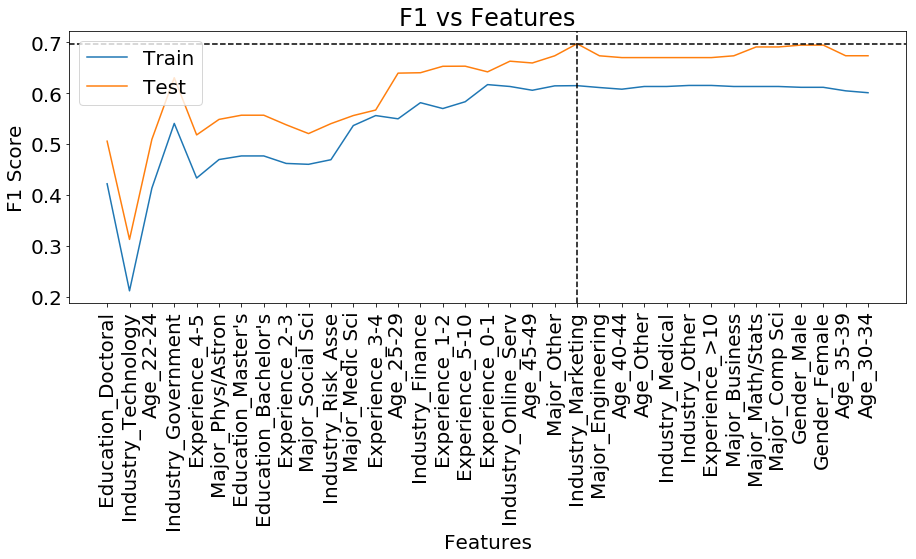

In [18]:
feature_plot(x, LogisticRegression(C=10), "f1")
# model = LogisticRegression(C=10)
# df_fin = pd.concat([x,y], axis=1)
# features = list(x.columns)
# target = list(y.columns)
# best = best_features(model, features, target, df_fin, 1000, "accuracy")
# fea_vs_metric(model, x, y, best, "accuracy")

In [19]:
get_idx()

In [20]:
%%time
compare_models(x[idx], "f1")

*** log_reg ***
BEST PARAMS                {'C': 100}
F1 on test data:           0.691
F1 on training data:         0.608
Accuracy on test data:     0.73
Accuracy on training data:   0.72
AUC on test data:          0.80
AUC on training data:        0.78

*** knn ***
BEST PARAMS                {'n_neighbors': 3}
F1 on test data:           0.611
F1 on training data:         0.691
Accuracy on test data:     0.69
Accuracy on training data:   0.77
AUC on test data:          0.73
AUC on training data:        0.83

*** ran_for ***
BEST PARAMS                {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 1}
F1 on test data:           0.635
F1 on training data:         0.611
Accuracy on test data:     0.69
Accuracy on training data:   0.70
AUC on test data:          0.72
AUC on training data:        0.74

*** gnb ***
BEST PARAMS                {'var_smoothing': 0.1}
F1 on test data:           0.650
F1 on training data:         0.582
Accuracy on test data:     0

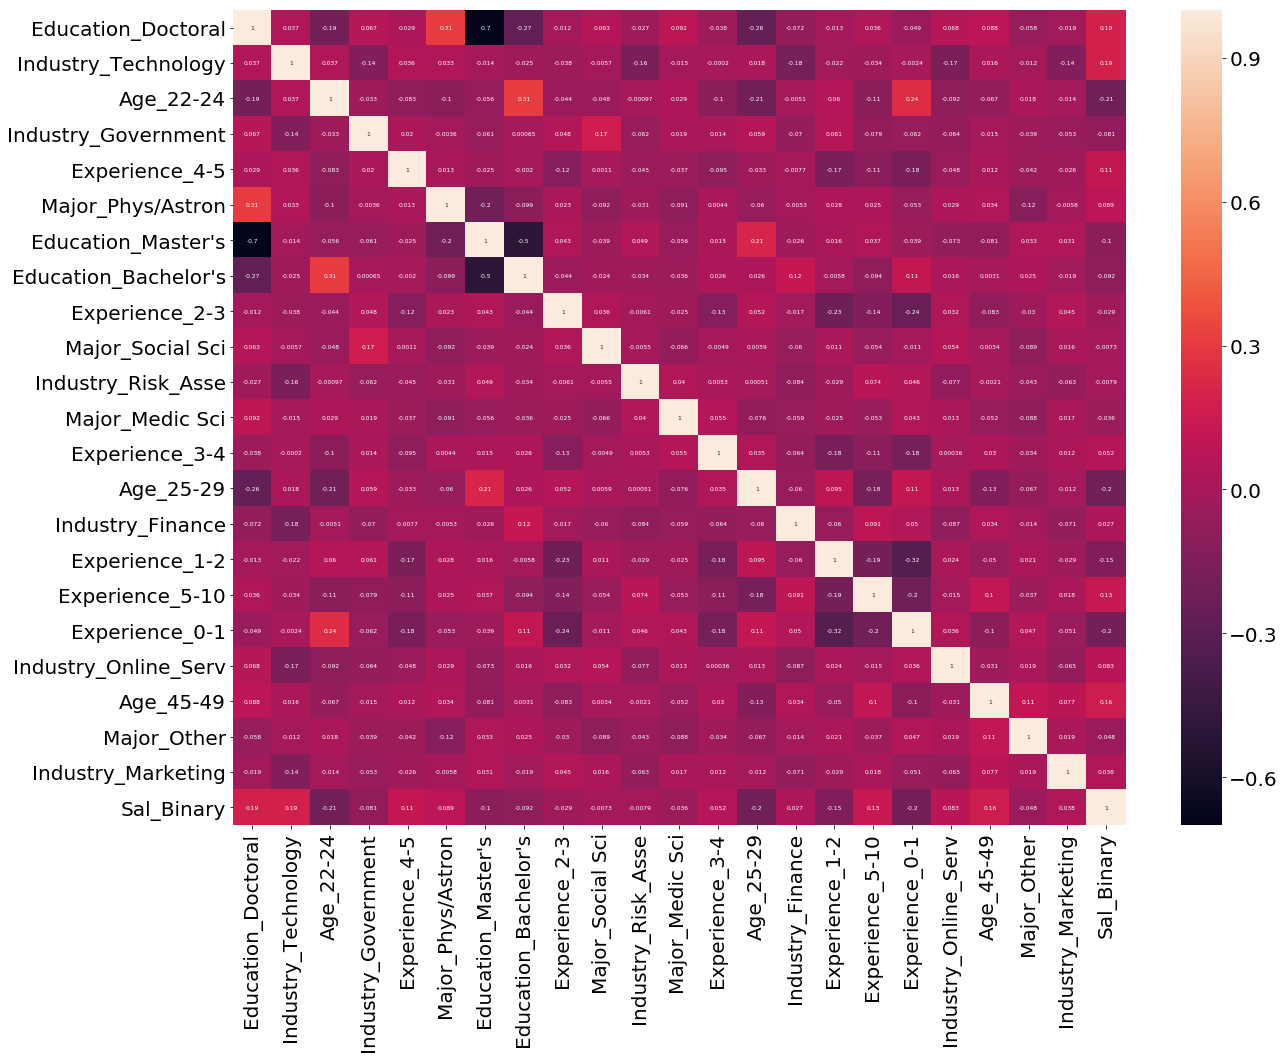

In [21]:
df_fin = pd.concat([x[best[:22]],y], axis=1)
corr = df_fin.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values, 
            annot = True, annot_kws={'size':6})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.show()

In [22]:
over_50perc_corr(df_fin)

Education_Doctoral  Education_Master's    0.700075
dtype: float64

In [23]:
%%time
compare_models(x[idx].drop("Education_Master's",axis=1), "f1")

# z = 0
# for name in mod:
#     print("*** " + mod[z] + " ***")
#     pick_model(name, x[best[:22]].drop("Education_Master's",axis=1), y, scoring="f1", detail=False, all_metrics=True)
#     z += 1

*** log_reg ***
BEST PARAMS                {'C': 100}
F1 on test data:           0.691
F1 on training data:         0.609
Accuracy on test data:     0.73
Accuracy on training data:   0.72
AUC on test data:          0.80
AUC on training data:        0.78

*** knn ***
BEST PARAMS                {'n_neighbors': 3}
F1 on test data:           0.567
F1 on training data:         0.701
Accuracy on test data:     0.65
Accuracy on training data:   0.78
AUC on test data:          0.71
AUC on training data:        0.84

*** ran_for ***
BEST PARAMS                {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 1}
F1 on test data:           0.605
F1 on training data:         0.658
Accuracy on test data:     0.68
Accuracy on training data:   0.75
AUC on test data:          0.69
AUC on training data:        0.79

*** gnb ***
BEST PARAMS                {'var_smoothing': 0.1}
F1 on test data:           0.650
F1 on training data:         0.569
Accuracy on test data:     

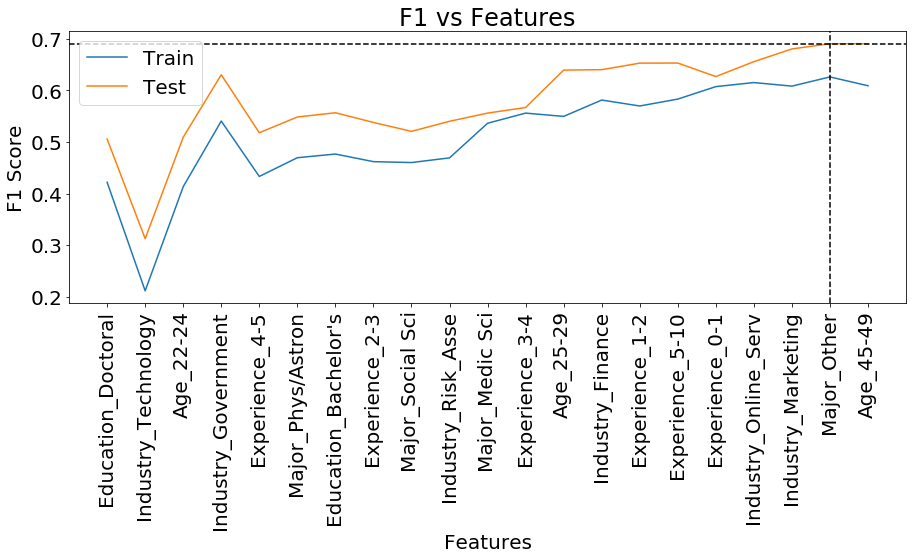

In [24]:
feature_plot(x[idx].drop("Education_Master's",axis=1), LogisticRegression(C=100), "f1")

# x2 = x[best[:22]].drop("Education_Master's",axis=1)

# df_fin2 = pd.concat([x2,y], axis=1)
# features2 = list(x2.columns)
# model = LogisticRegression(C=100)

# best2 = best_features(model, features2, target, df_fin2, 1000, "f1")
# fea_vs_metric(model, x2, y, best2, "f1")

In [25]:
get_idx()

In [26]:
# %%time
# compare_models(x[idx], "f1")

# mod = ["log_reg", "knn", "ran_for", "gnb", "xgb"]

# z = 0
# for name in mod:
#     print("*** " + mod[z] + " ***")
#     pick_model(name, x2.drop("Age_45-49",axis=1), y, scoring="f1", detail=False, all_metrics=True)
#     z += 1

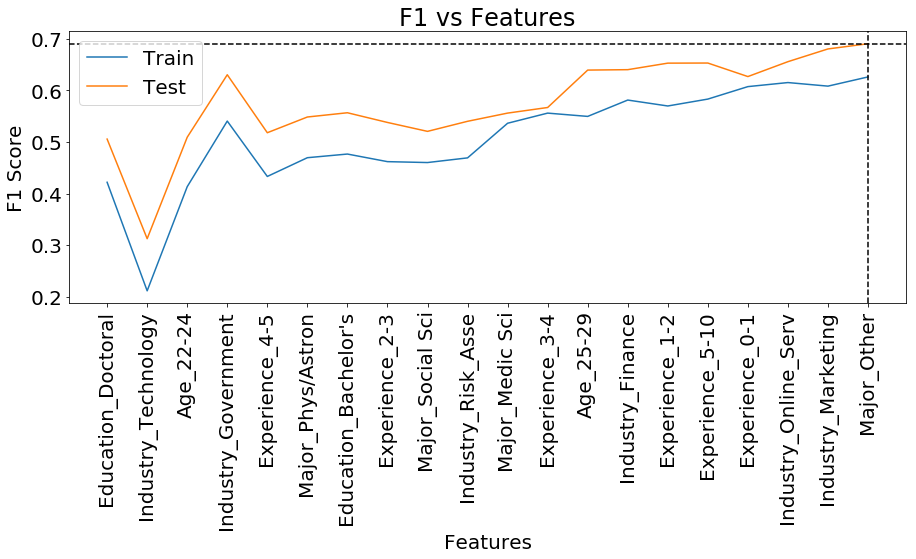

In [27]:
feature_plot(x[idx], LogisticRegression(C=100), "f1")

# x3= x2.drop("Age_45-49",axis=1)

# df_fin3 = pd.concat([x3,y], axis=1)
# features3 = list(x3.columns)
# model = LogisticRegression(C=100)

# best3 = best_features(model, features3, target, df_fin3, 1000, "f1")
# fea_vs_metric(model, x3, y, best3, "f1")

BEST PARAMS                {'C': 100}
F1 on test data:           0.691
F1 on training data:         0.626
Confusion Matrix on test data:
 [[99 24]
 [36 67]]
Classification Report on test data:
               precision    recall  f1-score   support

       False       0.73      0.80      0.77       123
        True       0.74      0.65      0.69       103

   micro avg       0.73      0.73      0.73       226
   macro avg       0.73      0.73      0.73       226
weighted avg       0.73      0.73      0.73       226



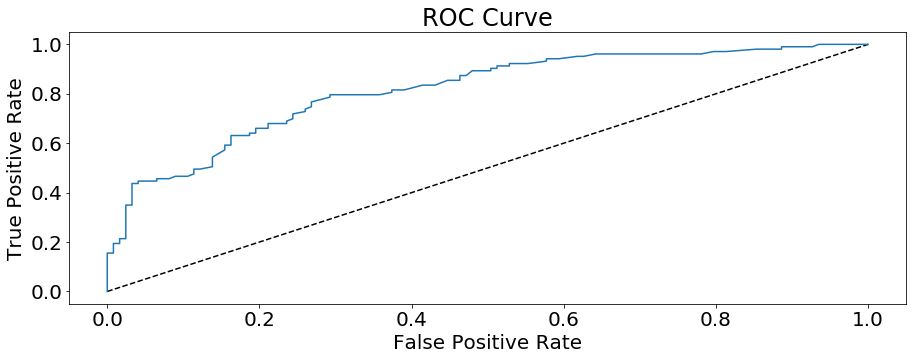

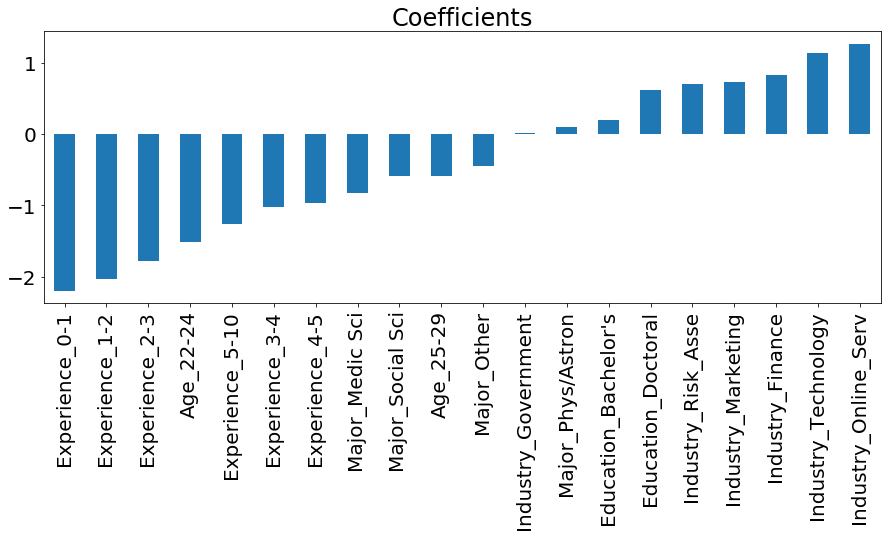

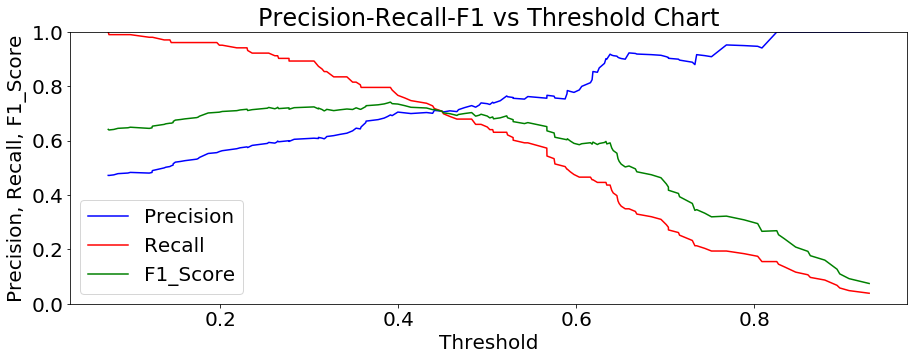

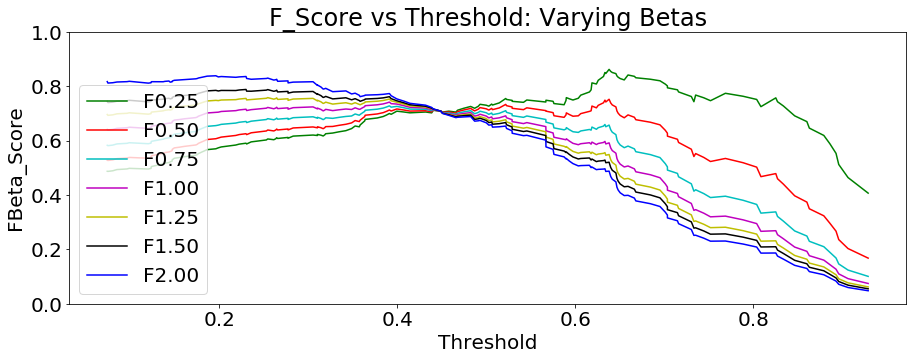

In [28]:
pick_model("log_reg", x[idx], y, scoring="f1", detail=True)

<div class = "span alert alert-success">
    <h2> Optimizing for Accuracy </h2>
    </div>

In [29]:
# features dfs

compare_models(x, "accuracy")

# x = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry', 'Experience']])

# # target df
# y = df[['Sal_Binary']]

# mod = ["log_reg", "knn", "ran_for", "gnb", "xgb"]

# z = 0
# for name in mod:
#     print("*** " + mod[z] + " ***")
#     pick_model(name, x, y, scoring="accuracy", detail=False, all_metrics=True)
#     z += 1

*** log_reg ***
BEST PARAMS                {'C': 0.1}
F1 on test data:           0.670
F1 on training data:         0.571
Accuracy on test data:     0.74
Accuracy on training data:   0.71
AUC on test data:          0.81
AUC on training data:        0.77

*** knn ***
BEST PARAMS                {'n_neighbors': 9}
F1 on test data:           0.630
F1 on training data:         0.582
Accuracy on test data:     0.70
Accuracy on training data:   0.71
AUC on test data:          0.75
AUC on training data:        0.78

*** ran_for ***
BEST PARAMS                {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}
F1 on test data:           0.480
F1 on training data:         0.548
Accuracy on test data:     0.65
Accuracy on training data:   0.72
AUC on test data:          0.79
AUC on training data:        0.83

*** gnb ***
BEST PARAMS                {'var_smoothing': 1e-05}
F1 on test data:           0.643
F1 on training data:         0.606
Accuracy on test data:   

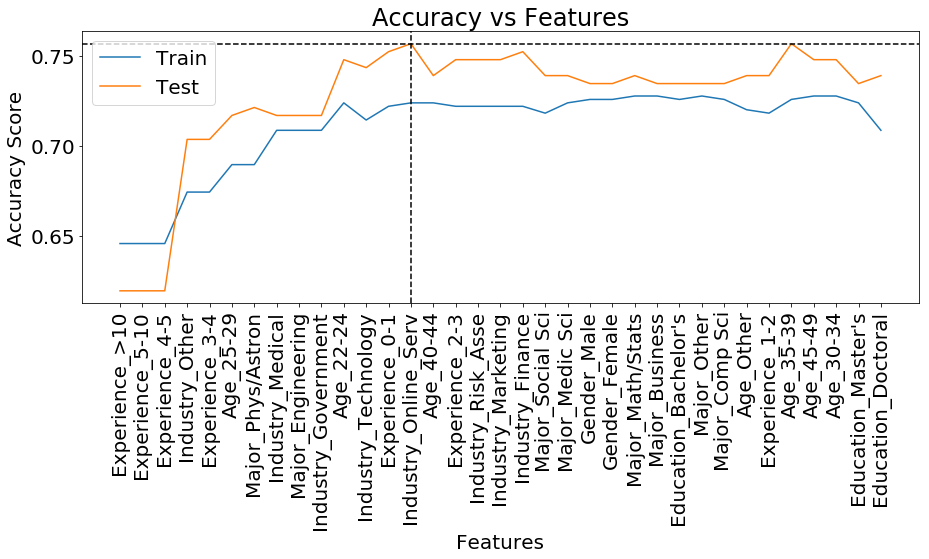

In [30]:
feature_plot(x, LogisticRegression(C=0.1), "accuracy")
get_idx()

# df_fin = pd.concat([x,y], axis=1)
# features = list(x.columns)
# target = list(y.columns)
# model = LogisticRegression(C=0.1)

# best = best_features(model, features, target, df_fin, 1000, "accuracy")
# fea_vs_metric(model, x, y, best, "accuracy")

In [31]:
# idx = best.index("Industry_Online_Serv")
# best[:(idx+1)]

In [32]:
%%time
compare_models(x[idx], "accuracy")

# %%time
# mod = ["log_reg", "knn", "ran_for", "gnb", "xgb"]

# z = 0
# for name in mod:
#     print("*** " + mod[z] + " ***")
#     pick_model(name, x[best[:(idx+1)]], y, scoring="accuracy", detail=False, all_metrics=True)
#     z += 1

*** log_reg ***
BEST PARAMS                {'C': 100}
F1 on test data:           0.698
F1 on training data:         0.603
Accuracy on test data:     0.75
Accuracy on training data:   0.72
AUC on test data:          0.82
AUC on training data:        0.76

*** knn ***
BEST PARAMS                {'n_neighbors': 9}
F1 on test data:           0.656
F1 on training data:         0.595
Accuracy on test data:     0.72
Accuracy on training data:   0.71
AUC on test data:          0.77
AUC on training data:        0.76

*** ran_for ***
BEST PARAMS                {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}
F1 on test data:           0.627
F1 on training data:         0.571
Accuracy on test data:     0.73
Accuracy on training data:   0.72
AUC on test data:          0.82
AUC on training data:        0.78

*** gnb ***
BEST PARAMS                {'var_smoothing': 0.1}
F1 on test data:           0.716
F1 on training data:         0.634
Accuracy on test data:     

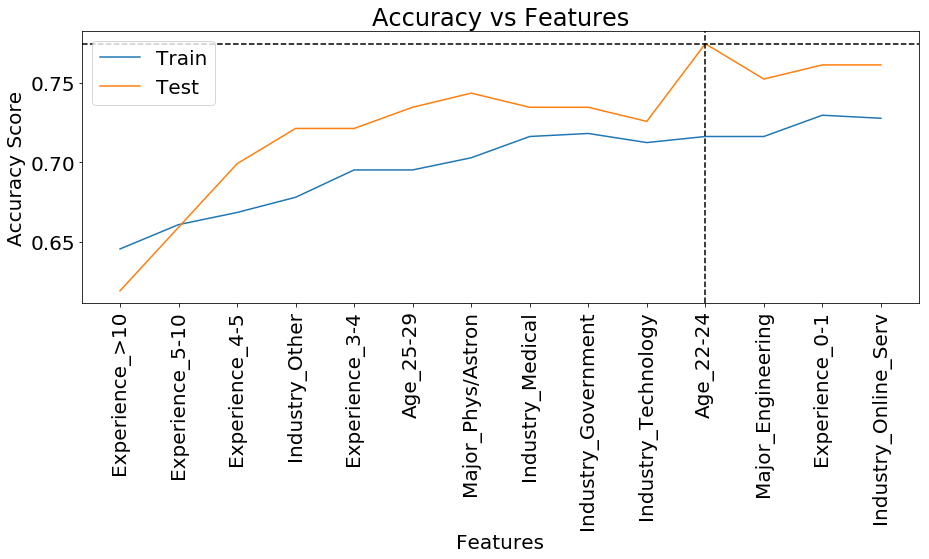

In [33]:
feature_plot(x[idx], XGBClassifier(alpha = 10, reg_lambda = 10, max_depth = 2), "accuracy")
get_idx()

# df_fin = pd.concat([x[best[:(idx+1)]],y], axis=1)
# features = list(x[best[:(idx+1)]].columns)
# target = list(y.columns)
# model = XGBClassifier(alpha = 10, reg_lambda = 10, max_depth = 2)

# best = best_features(model, features, target, df_fin, 1000, "accuracy")
# fea_vs_metric(model, x[best[:(idx+1)]], y, best, "accuracy")

In [34]:
# idx = best.index("Age_22-24")
# best[:(idx+1)]

In [35]:
%%time
compare_models(x[idx], "accuracy")

# %%time
# mod = ["log_reg", "knn", "ran_for", "gnb", "xgb"]

# z = 0
# for name in mod:
#     print("*** " + mod[z] + " ***")
#     pick_model(name, x[best[:(idx+1)]], y, scoring="accuracy", detail=False, all_metrics=True)
#     z += 1

*** log_reg ***
BEST PARAMS                {'C': 1}
F1 on test data:           0.703
F1 on training data:         0.597
Accuracy on test data:     0.76
Accuracy on training data:   0.71
AUC on test data:          0.82
AUC on training data:        0.75

*** knn ***
BEST PARAMS                {'n_neighbors': 9}
F1 on test data:           0.729
F1 on training data:         0.583
Accuracy on test data:     0.78
Accuracy on training data:   0.71
AUC on test data:          0.78
AUC on training data:        0.74

*** ran_for ***
BEST PARAMS                {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 1}
F1 on test data:           0.582
F1 on training data:         0.560
Accuracy on test data:     0.69
Accuracy on training data:   0.72
AUC on test data:          0.67
AUC on training data:        0.74

*** gnb ***
BEST PARAMS                {'var_smoothing': 0.1}
F1 on test data:           0.716
F1 on training data:         0.617
Accuracy on test data:     0.75


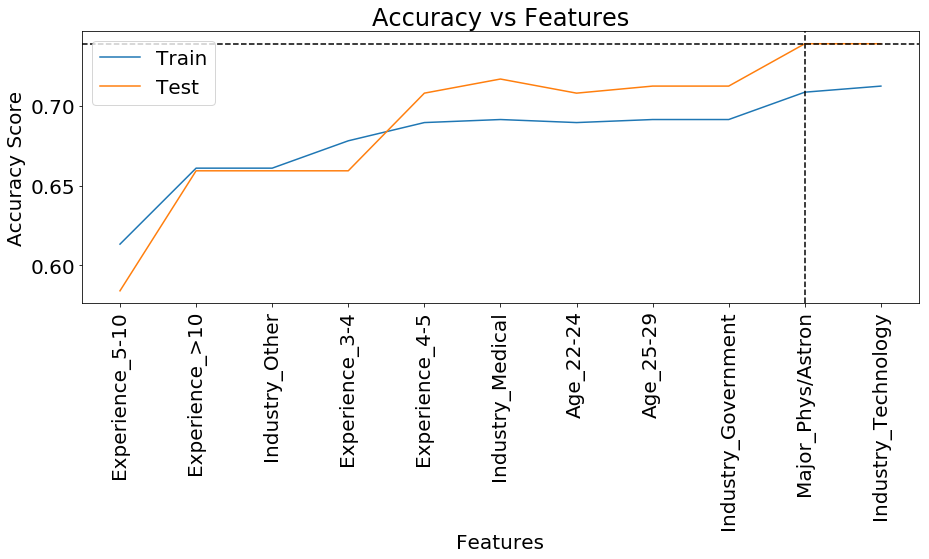

In [36]:
feature_plot(x[idx], KNeighborsClassifier(n_neighbors=9), "accuracy")
get_idx()

# df_fin = pd.concat([x[best[:(idx+1)]],y], axis=1)
# features = list(x[best[:(idx+1)]].columns)
# target = list(y.columns)
# model = KNeighborsClassifier(n_neighbors=9)

# best = best_features(model, features, target, df_fin, 1000, "accuracy")
# fea_vs_metric(model, x[best[:(idx+1)]], y, best, "accuracy")

In [37]:
%%time
compare_models(x[idx], "accuracy")

*** log_reg ***
BEST PARAMS                {'C': 1}
F1 on test data:           0.663
F1 on training data:         0.567
Accuracy on test data:     0.74
Accuracy on training data:   0.72
AUC on test data:          0.81
AUC on training data:        0.75

*** knn ***
BEST PARAMS                {'n_neighbors': 9}
F1 on test data:           0.663
F1 on training data:         0.557
Accuracy on test data:     0.74
Accuracy on training data:   0.71
AUC on test data:          0.78
AUC on training data:        0.75

*** ran_for ***
BEST PARAMS                {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}
F1 on test data:           0.632
F1 on training data:         0.572
Accuracy on test data:     0.72
Accuracy on training data:   0.72
AUC on test data:          0.79
AUC on training data:        0.76

*** gnb ***
BEST PARAMS                {'var_smoothing': 0.1}
F1 on test data:           0.691
F1 on training data:         0.584
Accuracy on test data:     0.73
